In [1]:
# set up the libraries
#    this list will grow as I progress through the project
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


In [2]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line during first run
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [3]:
# used to read table from PDF to get crime data

!pip install tabula-py # uncomment this line during first run
from tabula import read_pdf

     |████████████████████████████████| 10.4MB 21.3MB/s eta 0:00:01


*Done with loading needed libraries.*

In [4]:
# get the list of ZIP codes
url = 'http://www.city-data.com/zipmaps/Austin-Texas.html'

page_response = requests.get(url, timeout=5)
page_content = BeautifulSoup(page_response.content, "html.parser")
zips = []
for a in page_content.select('.zip-codes a'):
    zips.append(a.text)

# now, form the ZIP codes dataframe
austin = pd.DataFrame(zips, columns=['ZIPcode'])

In [5]:
austin.head()

,ZIPcode
0,78610
1,78613
2,78617
3,78641
4,78652


In [6]:
# now, let's get the geo coordinates for each ZIP code
geolocator = Nominatim(user_agent="aus_explorer")
lats = []
longs = []
for address in zips:
    location = geolocator.geocode(address)
    lats.append(location.latitude)
    longs.append(location.longitude)

# ... and add them to the data frame
austin['Latitude'] = lats
austin['Longitude'] = longs
austin.head()

,ZIPcode,Latitude,Longitude
0,78610,48.696388,1.853124
1,78613,30.528185,-97.859235
2,78617,30.156825,-97.618080
3,78641,30.606697,-97.890545
4,78652,30.132437,-97.837205


In [7]:
# next, let's get the venues within a ZIP code from FourSquare and create ZIP profiles
CLIENT_ID = 'SUQ***********************************XMW'
CLIENT_SECRET = 'NO*************************************MN'
VERSION = '20180605'

radius = 1000 # distance in meters from the focal point
LIMIT = 200  # number of results returned by FourSquare

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    tmp_df=pd.DataFrame()
    tmp_df['zip1']=names
    tmp_df['lat1']=latitudes
    tmp_df['long1']=longitudes
    for i in range(0,len(tmp_df)):
        name = tmp_df.iloc[i,0]
        lat = tmp_df.iloc[i,1]
        lng = tmp_df.iloc[i,2]
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIPcode', 
                  'ZIP Latitude', 
                  'ZIP Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
austin_venues = getNearbyVenues(names=austin['ZIPcode'],
                                latitudes=austin['Latitude'],
                                longitudes=austin['Longitude']
                               )

In [9]:
# next, I create the ZIP code profiles
# one hot encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")

# add ZIPcode column back to dataframe
austin_onehot['ZIPcode'] = austin_venues['ZIPcode'] 

# move ZIPcode column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]
austin_grouped = austin_onehot.groupby('ZIPcode').mean().reset_index()

In [10]:
# and the most popular venue types by ZIP code are:
top_venues = 10

for zipcode in austin_grouped['ZIPcode']:
    print("---- "+zipcode+" ----")
    temp = austin_grouped[austin_grouped['ZIPcode'] == zipcode].T.reset_index()
    temp.columns = ['venue category','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

---- 78610 ----
            venue category  freq
0            Train Station   1.0
1           Adult Boutique   0.0
2                     Park   0.0
3                   Museum   0.0
4              Music Store   0.0
5              Music Venue   0.0
6               Nail Salon   0.0
7          Nature Preserve   0.0
8  New American Restaurant   0.0
9             Night Market   0.0


---- 78613 ----
        venue category  freq
0                 Park  0.21
1                 Pool  0.14
2         Tennis Court  0.07
3           Non-Profit  0.07
4   Mexican Restaurant  0.07
5           Playground  0.07
6     Basketball Court  0.07
7  Arts & Crafts Store  0.07
8                  Pub  0.07
9          Art Gallery  0.07


---- 78641 ----
                  venue category  freq
0                           Farm   0.5
1                            Gym   0.5
2                 Adult Boutique   0.0
3  Paper / Office Supplies Store   0.0
4                    Music Store   0.0
5                    Music Venue

In [11]:
# now I need to run the k-means cluster analysis
### first, I need to determine the optimum number of clusters
### I will do that using hte Elbow method

### so, let's transform the most common categories into a data frame
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZIPcode']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['ZIPcode'] = austin_grouped['ZIPcode']

for ind in np.arange(austin_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], 
                                                                     top_venues)


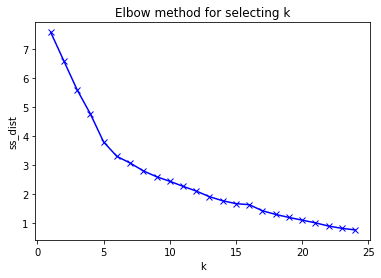

In [12]:
### now, determine the optimum K
austin_clustering = austin_grouped.drop('ZIPcode', axis=1)
ss_dist = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(austin_clustering)
    ss_dist.append(km.inertia_)

plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('ss_dist')
plt.title('Elbow method for selecting k')
plt.show()

In [13]:
# now get the clusters
k=8
km = KMeans(n_clusters=k, random_state=0).fit(austin_clustering)

zipcodes_venues_sorted.insert(0, 'Cluster Labels', km.labels_)

austin_merged = austin

# merge austin_grouped with austin data to add latitude/longitude for each ZIP code
austin_merged = austin_merged.join(zipcodes_venues_sorted.set_index('ZIPcode'), on='ZIPcode')

austin_merged.head()

,ZIPcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78610,48.696388,1.853124,2.0,Train Station,Yoga Studio,Donut Shop,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,Fast Food Restaurant,Farmers Market
1,78613,30.528185,-97.859235,5.0,Park,Pool,Tennis Court,Playground,Pizza Place,Non-Profit,Basketball Court,Pub,Mexican Restaurant,Arts & Crafts Store
2,78617,30.156825,-97.618080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78641,30.606697,-97.890545,4.0,Farm,Gym,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Field
4,78652,30.132437,-97.837205,5.0,Mexican Restaurant,Home Service,Hardware Store,Business Service,Locksmith,Flea Market,Flower Shop,Food,Ethiopian Restaurant,Field


In [14]:
# create map
address = 'Austin, TX'

geolocator = Nominatim(user_agent="aus_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width=1000, height=1000)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []


tmp_df=pd.DataFrame()
tmp_df['lat']=austin_merged['Latitude']
tmp_df['lng']=austin_merged['Longitude']
tmp_df['zcode']=austin_merged['ZIPcode']
tmp_df['cl_lbl']=austin_merged['Cluster Labels']

# tmp_df1 = tmp_df.dropna(subset=['cl_lbl'])
tmp_df1 = tmp_df.fillna(value={'cl_lbl': 5})
tmp_df1 = tmp_df1.astype({'cl_lbl': int})

for i in range(0,len(tmp_df1)):
    lat = tmp_df1.iloc[i,0]
    lon = tmp_df1.iloc[i,1]
    poi = tmp_df1.iloc[i,2]
    cluster = tmp_df1.iloc[i,3]
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now, let's get the crime data in

In [15]:
austin_crime = read_pdf("http://www.austintexas.gov/sites/default/files/files/Police/Indx_Nindx_zip_122017.pdf",
                        pages='all', pandas_options={'header':None})
colnames = ['ZIPcode', 'Murder', 'Rape', 'Robbery', 'AggAssult', 'Burglary', 'Theft', 'MotorVtheft',
           'Arson', 'Totindexed', 'TotNonIndexed', 'TotCombined']
austin_crime.columns = colnames

In [16]:
# clean up the df and convert all cols to number
austin_crime.drop(48, axis=0, inplace=True)
austin_crime['AggAssult'] = pd.to_numeric(austin_crime['AggAssult'])
austin_crime['Burglary'] = pd.to_numeric(austin_crime['Burglary'])
austin_crime['Theft'] = pd.to_numeric(austin_crime['Theft'].str.replace(',', ''))
austin_crime['MotorVtheft'] = pd.to_numeric(austin_crime['MotorVtheft'])
austin_crime['Totindexed'] = pd.to_numeric(austin_crime['Totindexed'].str.replace(',', ''))
austin_crime['TotNonIndexed'] = pd.to_numeric(austin_crime['TotNonIndexed'].str.replace(',', ''))
austin_crime['TotCombined'] = pd.to_numeric(austin_crime['TotCombined'].str.replace(',', ''))
austin_crime.fillna(0, inplace=True)

# now group crimes into 2 types and move summary data to a new df
austin_crime['Violent'] = austin_crime.Murder + austin_crime.Rape + austin_crime.AggAssult
austin_crime['Property'] = austin_crime.Robbery + austin_crime.Burglary + austin_crime.Theft + austin_crime.MotorVtheft + austin_crime.Arson

austin_crime_comb = austin_crime[['ZIPcode', 'Totindexed', 'TotNonIndexed', 'TotCombined', 'Violent', 'Property']]

In [17]:
# add the prepped crime data to the merged df
austin_merged = austin_merged.join(austin_crime_comb.set_index('ZIPcode'), on='ZIPcode')


### Now, let's take a look at the cluster composition

***Cluster 1***

In [18]:
austin_merged.loc[austin_merged['Cluster Labels'] == 0, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
33,30.212667,-97.928105,78737,Yoga Studio,Dry Cleaner,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,Fast Food Restaurant,2.0,4.0,6.0,0.0,2.0


***Cluster 2***

In [19]:
austin_merged.loc[austin_merged['Cluster Labels'] == 1, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
32,30.244068,-97.924664,78736,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,108.0,166.0,274.0,9.0,99.0


***Cluster 3***

In [20]:
austin_merged.loc[austin_merged['Cluster Labels'] == 2, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
0,48.696388,1.853124,78610,Donut Shop,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,Fast Food Restaurant,Farmers Market,NaN,NaN,NaN,NaN,NaN


***Cluster 4***

In [21]:
austin_merged.loc[austin_merged['Cluster Labels'] == 3, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
35,30.177395,-97.882753,78739,Donut Shop,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,Fast Food Restaurant,Farmers Market,102.0,211.0,313.0,5.0,97.0


***Cluster 5***

In [22]:
austin_merged.loc[austin_merged['Cluster Labels'] == 4, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
3,30.606697,-97.890545,78641,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,NaN,NaN,NaN,NaN,NaN
8,30.475704,-97.765448,78681,Yoga Studio,Intersection,Spa,Coffee Shop,Light Rail Station,Sushi Restaurant,Golf Course,Grocery Store,NaN,NaN,NaN,NaN,NaN
22,30.434150,-97.839109,78726,Trail,Pool,Moving Target,Photography Studio,Furniture / Home Store,Electronics Store,Ethiopian Restaurant,Event Service,235.0,468.0,703.0,33.0,202.0
27,30.321464,-97.755010,78731,Food Truck,Flower Shop,Sandwich Place,Department Store,Cemetery,Ethiopian Restaurant,Event Service,Fabric Shop,468.0,777.0,1245.0,23.0,445.0
29,30.330944,-97.866608,78733,Coffee Shop,Bakery,Lake,Grocery Store,Business Service,Flea Market,Field,Fast Food Restaurant,1.0,5.0,6.0,0.0,1.0
44,30.461831,-97.748882,78750,Coffee Shop,Yoga Studio,Electronics Store,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,437.0,1006.0,1443.0,23.0,414.0


***Cluster 6***

In [23]:
austin_merged.loc[austin_merged['Cluster Labels'] == 5, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
1,30.528185,-97.859235,78613,Tennis Court,Playground,Pizza Place,Non-Profit,Basketball Court,Pub,Mexican Restaurant,Arts & Crafts Store,312.0,191.0,503.0,8.0,304.0
4,30.132437,-97.837205,78652,Hardware Store,Business Service,Locksmith,Flea Market,Flower Shop,Food,Ethiopian Restaurant,Field,10.0,33.0,43.0,1.0,9.0
7,30.516208,-97.662623,78664,Pizza Place,Pharmacy,Park,Chinese Restaurant,Bank,Café,Burger Joint,Sandwich Place,NaN,NaN,NaN,NaN,NaN
9,30.280466,-97.750088,78701,American Restaurant,Hotel,Mexican Restaurant,Pet Store,Sushi Restaurant,Sports Bar,Museum,Sandwich Place,1940.0,6657.0,8597.0,185.0,1755.0
10,30.278460,-97.718800,78702,Cocktail Bar,Park,Coffee Shop,Baseball Field,Sandwich Place,Mexican Restaurant,BBQ Joint,Gym / Fitness Center,1643.0,3789.0,5432.0,146.0,1497.0
11,30.271561,-97.761267,78703,Park,Yoga Studio,Grocery Store,Gym / Fitness Center,Theater,Coffee Shop,Diner,Gym,619.0,1043.0,1662.0,18.0,601.0
12,30.227821,-97.778097,78704,Fast Food Restaurant,Video Store,Cosmetics Shop,Convenience Store,Martial Arts Dojo,Business Service,Chinese Restaurant,Burger Joint,2520.0,4745.0,7265.0,134.0,2386.0
13,30.288272,-97.727404,78705,Food Truck,Mexican Restaurant,Taco Place,Pub,Performing Arts Venue,Fast Food Restaurant,Theater,College Gym,908.0,1507.0,2415.0,54.0,854.0
14,30.284714,-97.735673,78712,History Museum,Clothing Store,Pool,Fast Food Restaurant,Student Center,Hotel,Taco Place,Food Truck,6.0,9.0,15.0,1.0,5.0
15,30.495895,-97.766232,78717,Ice Cream Shop,Optical Shop,Pool,Playground,Pizza Place,Cosmetics Shop,Dance Studio,Park,328.0,604.0,932.0,28.0,300.0


***Cluster 7***

In [24]:
austin_merged.loc[austin_merged['Cluster Labels'] == 6, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
48,30.388409,-97.633298,78754,Dry Cleaner,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Field,Fast Food Restaurant,494.0,901.0,1395.0,28.0,466.0


***Cluster 8***

In [25]:
austin_merged.loc[austin_merged['Cluster Labels'] == 7, 
                        austin_merged.columns[[1] + [2] + [0]
                                               + list(range(6, austin_merged.shape[1]))]]

,Latitude,Longitude,ZIPcode,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Totindexed,TotNonIndexed,TotCombined,Violent,Property
40,30.308162,-97.789878,78746,Boat Rental,Lake,Fast Food Restaurant,Event Service,Fabric Shop,Farm,Farmers Market,Yoga Studio,806.0,619.0,1425.0,9.0,797.0


### Finally, let's take a look at some summary statistics

**Number of ZIP codes per cluster:**

In [37]:
austin_clusters = austin_merged[['ZIPcode','Cluster Labels']]
austin_clusters.groupby('Cluster Labels').count()

,ZIPcode
Cluster Labels,
0.0,1
1.0,1
2.0,1
3.0,1
4.0,6
5.0,35
6.0,1
7.0,1


**Average (mean) crime stats per cluster**

In [39]:
austin_cluster_crime_stats = austin_merged[['Cluster Labels', 'Violent', 'Property', 'Totindexed', 'TotNonIndexed', 'TotCombined']]
austin_cluster_crime_stats.groupby('Cluster Labels').mean()

,Violent,Property,Totindexed,TotNonIndexed,TotCombined
Cluster Labels,,,,,
0.0,0.000000,2.000000,2.000000,4.00000,6.000000
1.0,9.000000,99.000000,108.000000,166.00000,274.000000
2.0,NaN,NaN,NaN,NaN,NaN
3.0,5.000000,97.000000,102.000000,211.00000,313.000000
4.0,19.750000,265.500000,285.250000,564.00000,849.250000
5.0,81.030303,893.424242,974.454545,2121.69697,3096.151515
6.0,28.000000,466.000000,494.000000,901.00000,1395.000000
7.0,9.000000,797.000000,806.000000,619.00000,1425.000000


**Get the number of venue per ZIP code**

In [40]:
austin_venues.groupby('ZIPcode').count()

,ZIP Latitude,ZIP Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIPcode,,,,,,
78610,1,1,1,1,1,1
78613,14,14,14,14,14,14
78641,2,2,2,2,2,2
78652,5,5,5,5,5,5
78664,40,40,40,40,40,40
78681,28,28,28,28,28,28
78701,98,98,98,98,98,98
78702,60,60,60,60,60,60
78703,100,100,100,100,100,100


In [43]:
austin_venues.groupby(['ZIPcode','Venue Category']).count()

ZIP Latitude  ZIP Longitude  Venue  \
ZIPcode Venue Category                                              
78610   Train Station                     1              1      1   
78613   Art Gallery                       1              1      1   
        Arts & Crafts Store               1              1      1   
        Basketball Court                  1              1      1   
        Mexican Restaurant                1              1      1   
        Non-Profit                        1              1      1   
        Park                              3              3      3   
        Pizza Place                       1              1      1   
        Playground                        1              1      1   
        Pool                              2              2      2   
        Pub                               1              1      1   
        Tennis Court                      1              1      1   
78641   Farm                              1              1      1   
        Gym                               1              1      1   
78652   Business Service                  1              1      1   
        Hardware Store                    1              1      1   
        Home Service                      1              1      1   
        Locksmith                         1              1      1   
        Mexican Restaurant                1              1      1   
78664   American Restaurant               1              1      1   
        Bank                              1              1      1   
        Burger Joint                      1              1      1   
        Café                              1              1      1   
        Chinese Restaurant                2              2      2   
        Convenience Store                 1              1      1   
        Dog Run                           1              1      1   
        Fast Food Restaurant              4              4      4   
        Frozen Yogurt Shop                1              1      1   
        Grocery Store                     1              1      1   
        Gym                               1              1      1   
...                                     ...            ...    ...   
78758   Sports Bar                        1              1      1   
        Storage Facility                  1              1      1   
        Taco Place                        2              2      2   
        Tailor Shop                       1              1      1   
        Video Game Store                  1              1      1   
        Vietnamese Restaurant             4              4      4   
        Yoga Studio                       1              1      1   
78759   BBQ Joint                         1              1      1   
        Bakery                            2              2      2   
        Bank                              1              1      1   
        Bike Shop                         1              1      1   
        Breakfast Spot                    1              1      1   
        Coffee Shop                       1              1      1   
        Convenience Store                 1              1      1   
        Discount Store                    1              1      1   
        Gas Station                       1              1      1   
        Grocery Store                     1              1      1   
        Hawaiian Restaurant               1              1      1   
        Health Food Store                 1              1      1   
        Indian Restaurant                 3              3      3   
        Italian Restaurant                1              1      1   
        Miscellaneous Shop                1              1      1   
        Park                              1              1      1   
        Pet Store                         1              1      1   
        Pizza Place                       3              3      3   
        Rental Car Location  

In [44]:
austin_venues.shape

(1309, 7)

In [45]:
austin_crime.shape

(48, 14)

In [49]:
austin_venues[['ZIPcode','Venue']].groupby('ZIPcode').count().describe()

,Venue
count,47.000000
mean,27.851064
std,28.278874
min,1.000000
25%,8.000000
50%,14.000000
75%,40.000000
max,100.000000


In [50]:
austin_venues.groupby(['Venue Category']).count()

,ZIPcode,ZIP Latitude,ZIP Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Adult Boutique,2,2,2,2,2,2
American Restaurant,27,27,27,27,27,27
Antique Shop,2,2,2,2,2,2
Art Gallery,11,11,11,11,11,11
Art Museum,3,3,3,3,3,3
Arts & Crafts Store,5,5,5,5,5,5
Asian Restaurant,9,9,9,9,9,9
Assisted Living,1,1,1,1,1,1
Athletics & Sports,10,10,10,10,10,10
